In [40]:
import matplotlib.pyplot as plt
from tqdm import trange,tqdm
import numpy as np
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import random_split

np.random.seed(0)
torch.manual_seed(0)

import os
if not os.path.isdir(f"Transformer_Ouputs"):
    os.makedirs("Transformer_Ouputs")

#  Train this VIT_model on the CIFAR-10 dataset for 10-class classification. Keep the number of attention layers to be 4 for all the experiments.

In [50]:
epochs=30
weight_decay=0.1
ngpu = 7
lr=10e-5
batch_size = 200

img_size=32
patch_size=4
in_channel=3
embedding_dim=768
num_heads=12
n_attention_layer=4
num_of_epochs=2
mlp_dropout =0.1
attn_dropout =0.1
num_classes=10
hidden_dim_scale= 4
has_attn_dropout=False
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [42]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dataset, valid_dataset = random_split(train_dataset, [len(train_dataset)-5000, 5000])

classes = test_dataset.classes
print("train_size:\t",len(train_dataset),"\ntest_size:\t",len(test_dataset),"\nvalid_size:\t",len(valid_dataset),"\nclasses:\t",classes)


train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

print("Batch Size: ",next(iter(train_loader))[0].shape)

Files already downloaded and verified
Files already downloaded and verified
train_size:	 45000 
test_size:	 10000 
valid_size:	 5000 
classes:	 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch Size:  torch.Size([200, 3, 32, 32])


### Patch and Position Embedding Class

1.  Generate **Patch Embedding** for given Image
2.  Generate **Position Embedding** for given Patch
3.  Apply Patch Embedding to Image and Add **CLS** Token
4.  Apply Position Embedding to Patch

In [43]:
class Patch_Position_Embedding(nn.Module):
    '''
    IN: Embedding_dim : out dimension,
        Patch_size: Size of each Patch,
        Image

    OUT: Patch_embedding + Position_embedding

    '''
    def __init__(self,patch_size=4,embedding_dim=768,in_channels=3):

        super().__init__()
        self.layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim , kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    def forward(self,x):

        patch_embedding = self.flatten(self.layer(x)).permute(0,2,1).to(device)
        cls_token = nn.Parameter(torch.ones(patch_embedding.shape[0], 1, patch_embedding.shape[2]),requires_grad=True).to(device)
        # print("cls_token",cls_token)
        position_embedding = nn.Parameter(torch.ones(patch_embedding.shape[0], 1+patch_embedding.shape[1], patch_embedding.shape[2]),requires_grad=True).to(device)
        # print("position_embedding",position_embedding)

        patch_embedding = torch.concat((cls_token,patch_embedding),dim=1)
        return patch_embedding + position_embedding

In [44]:
class MultiHeadAttention(nn.Module):
    '''
    parameters: embedding_dim, num_heads=12 (Default), attn_dropout:float=0.1 (default),has_attn_dropout: False(default)
    Function: Generate the MultiHead Attention Module Of Transformer VIT_model
    q_layer
    '''
    def __init__(self,embedding_dim,num_heads=12, attn_dropout:float=0.1 ,has_attn_dropout=False):
        super().__init__()
        self.num_heads = num_heads
        self.embedding_dim= embedding_dim
        self.head_dim = embedding_dim // num_heads
        self.attn_dropout =  attn_dropout
        self.layerNorm1 = nn.LayerNorm(embedding_dim , eps = 1e-7)

        self.q_layer = nn.Linear(embedding_dim, embedding_dim)
        self.k_layer = nn.Linear(embedding_dim, embedding_dim)
        self.v_layer = nn.Linear(embedding_dim, embedding_dim)
        self.has_attn_dropout = has_attn_dropout
        if self.has_attn_dropout:
            self.dropout = nn.Dropout(p=self.attn_dropout)

    def forward(self,x):
        n_sample, n_patch , dim = x.shape
        x = self.layerNorm1(x)

        Q = self.q_layer(x)
        K = self.k_layer(x)
        V = self.v_layer(x)

        Q = Q.view(n_sample, -1, self.num_heads, self.head_dim)
        K = K.view(n_sample, -1, self.num_heads, self.head_dim)
        V = V.view(n_sample, -1, self.num_heads, self.head_dim)

        Q = Q.transpose(1,2)
        K = K.transpose(1,2)
        V = V.transpose(1,2)

        ##### Dot Product with pixel Normalization #####
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        # print("scores",scores)

        atten_matrix = torch.softmax(scores,dim =-1)
        # print("atten_matrix",atten_matrix)
        attn_output = torch.matmul(atten_matrix, V)
        if self.has_attn_dropout:
            attn_output = self.dropout(attn_output)
        attn_output = attn_output.transpose(1,2).flatten(2)
        return attn_output

In [45]:
class MLP(nn.Module):
    '''
    Multi-Layer Perceptron : Generate MultiLayer Perceptron with two Linear Layers and 1 GELU Function
    Parameters: embedding_dim: int, hidden_dim_scale: int = 4 (Default), mlp_dropout:float = 0.1 (Default)
    Output: X processed through MLP Layer
    '''
    def __init__(self, embedding_dim: int, hidden_dim_scale: int = 4, mlp_dropout:float = 0.1):
        super().__init__()
        self.main = nn.Sequential(
                nn.LayerNorm(embedding_dim , eps = 1e-6),
                nn.Linear(embedding_dim, hidden_dim_scale * embedding_dim),
                nn.GELU(),
                nn.Dropout(p=mlp_dropout),

                nn.Linear(hidden_dim_scale * embedding_dim, embedding_dim),
                nn.Dropout(p=mlp_dropout)
            )

    def forward(self,x):

        return self.main(x)

In [46]:
class TransformerEncoderBlock(nn.Module):
    '''
    Parameters: self,embedding_dim:int,
                 num_heads:int,
                 hidden_dim_scale: int = 4,
                 mlp_dropout:float = 0.1,
                 attn_dropout:float=0.1 ,
                 has_attn_dropout=False
    Functioning:  Perform  x+ MultiheadAttention(x) => x+ MLP(x) => return value
    '''
    def __init__(self,embedding_dim:int,
                 num_heads:int,
                 hidden_dim_scale: int = 4,
                 mlp_dropout:float = 0.1,
                 attn_dropout:float=0.1 ,
                 has_attn_dropout=False):
        super(TransformerEncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(embedding_dim=embedding_dim , num_heads=num_heads, attn_dropout=attn_dropout ,has_attn_dropout=has_attn_dropout)
        self.mlp = MLP(embedding_dim=embedding_dim,hidden_dim_scale=hidden_dim_scale,mlp_dropout=mlp_dropout)

    def forward(self, x):
        x = x + self.mha(x)
        x = x + self.mlp(x)
        return x


In [47]:
class VisionTransformer(nn.Module):
    '''
    Parameters:  img_size:int,
                 patch_size :int,
                 in_channel: int=3,
                 embedding_dim:int = 768 ,
                 num_heads :int = 12,
                 n_attention_layer:int=4,
                 hidden_dim_scale: int = 4,
                 mlp_dropout : float = 0.1,
                 attn_dropout: float=0.1 ,
                 has_attn_dropout=False

    Functioning:  Classify with the help of CLS Token(Classify the Image)
    Process: 1. Generate Patch_Position_Embedding
             2. Perform Transfomer_Encoding n_attention_layer times
             3.Perfom layer Norm
             4.Classify using Linear Classifier.

    '''
    def __init__(self,img_size:int,
                 patch_size :int,
                 in_channel: int=3,
                 embedding_dim:int = 768 ,
                 num_heads :int = 8,
                 n_attention_layer:int=2,
                 hidden_dim_scale: int = 4,
                 mlp_dropout : float = 0.1,
                 attn_dropout: float=0.1 ,
                 has_attn_dropout=False ):

        super(VisionTransformer,self).__init__()

        self.n_attention_layer = n_attention_layer
        self.patch_position_embedding = Patch_Position_Embedding(patch_size=patch_size,embedding_dim=embedding_dim,in_channels=in_channel)
        self.blocks = nn.ModuleList(
            [
                TransformerEncoderBlock(embedding_dim = embedding_dim ,
                                        num_heads = num_heads,
                                        hidden_dim_scale=hidden_dim_scale,
                                        mlp_dropout=mlp_dropout,
                                        attn_dropout=attn_dropout,
                                        has_attn_dropout=has_attn_dropout)

                for _ in range(n_attention_layer)
            ]
        )

        self.layerNorm = nn.LayerNorm(embedding_dim , eps = 1e-6)
        self.classfier = nn.Sequential(
            nn.Linear(embedding_dim, 10),
            nn.Tanh()
        )

    def forward(self,x,n_layer=4):
        x = self.patch_position_embedding(x)
        for i in range(n_layer): x = self.blocks[i](x)
        x = self.layerNorm(x)
        # print("x",x)
        cls_token_final = x[:,0]
        # print(" cls_token_final", cls_token_final)
        x = self.classfier(cls_token_final)
        return x

In [48]:
def train_model(model,optimizer,loss_function,
                train_loader,
                val_loader,
                test_loader,
                num_classes=10,
                num_of_epochs=2,
                valid_loader=None,
                ):

    def accuracy_score():
        correct = 0
        total = 0
        with torch.no_grad():
            print("\n #######Calculating Train Accuracy########")
            for batch_id,(x,y) in  tqdm(enumerate(train_loader)):
                optimizer.zero_grad()

                y = F.one_hot(y, num_classes=10).float().to(device)
                x = x.to(device)
                outputs = model(x)
                # print("outputs",outputs)

                _, predicted = torch.max(outputs.data, 1)
                # print( "_, predicted", _, predicted)

                # Compute the number of correctly predicted labels
                total += y.size(0)
                correct += (predicted == torch.argmax(y, dim=1)).sum().item()

            # Compute the accuracy as the percentage of correctly predicted labels
            train_accuracy = 100 * correct / total

            ##### validation_set_Accuracy ######
            correct ,total = 0,0
            print("\n #######Calculating Valid Accuracy########")

            for batch_id,(x,y) in  tqdm(enumerate(val_loader)):
                optimizer.zero_grad()

                y = F.one_hot(y, num_classes=10).float().to(device)
                x = x.to(device)
                outputs = model(x)

                _, predicted = torch.max(outputs.data, 1)

                # Compute the number of correctly predicted labels
                total += y.size(0)
                correct += (predicted == torch.argmax(y, dim=1)).sum().item()
            val_accuracy = 100 * correct / total

            ##### Test_set_Accuracy ######
            correct ,total = 0,0
            print("\n ##### Calculating Test Accuracy")
            for batch_id,(x,y) in  tqdm(enumerate(test_loader)):
                optimizer.zero_grad()

                y = F.one_hot(y, num_classes=10).float().to(device)
                x = x.to(device)
                outputs = model(x)

                _, predicted = torch.max(outputs.data, 1)

                # Compute the number of correctly predicted labels
                total += y.size(0)
                correct += (predicted == torch.argmax(y, dim=1)).sum().item()
            test_accuracy = 100 * correct / total

        print(f" Total_Number_of_Epochs: {num_of_epochs}, Train_Accuracy: {train_accuracy:.2f}%    Valid_Accuracy: {val_accuracy:.2f}%    Test_Accuracy: {test_accuracy:.2f}%")
        return [train_accuracy, val_accuracy, test_accuracy]






    ############ Training###################
    batch_losses = []
    print("Training Started")
    for epoch in range(num_of_epochs):

        train_loss, val_loss = 0.0,0.0
        for batch_id,(x,y) in  enumerate(train_loader):
            optimizer.zero_grad()
            y = y.to(device)
            y = F.one_hot(y, num_classes=10).float().to(device)

            x = x.to(device)
            outputs = model(x)

            loss = loss_function(outputs, y)
            batch_losses.append(loss.item())
            train_loss += loss.item()
            loss.backward()


            optimizer.step()


            if (batch_id+1)%50==0 :
                with torch.no_grad():
                    for _,(x,y) in  enumerate(val_loader):
                        optimizer.zero_grad()
                        y = y.to(device)
                        y = F.one_hot(y, num_classes=10).float().to(device)

                        x = x.to(device)
                        outputs = model(x)

                        loss = loss_function(outputs, y)
                        val_loss += loss.item()
                val_loss=val_loss/len(val_loader)

                train_loss = train_loss/50
                print(f"Epoch: [{epoch+1}/{num_of_epochs}] \t batch: [{batch_id+1}/{len(train_loader)}]   Training loss: {train_loss:.8f}  Validation_loss: {val_loss:.8f}")
                train_loss=0.0
                val_loss=0.0





    ########### Accuracy Score ###################
    train_accuracy, val_accuracy, test_accuracy = accuracy_score()

    return [batch_losses,train_accuracy, val_accuracy, test_accuracy]

Training Started
Epoch: [1/2] 	 batch: [50/225]   Training loss: 2.24911219  Validation_loss: 2.21617897
Epoch: [1/2] 	 batch: [100/225]   Training loss: 2.19981613  Validation_loss: 2.19503522
Epoch: [1/2] 	 batch: [150/225]   Training loss: 2.14985712  Validation_loss: 2.14157403
Epoch: [1/2] 	 batch: [200/225]   Training loss: 2.10897125  Validation_loss: 2.08860856
Epoch: [2/2] 	 batch: [50/225]   Training loss: 2.05135565  Validation_loss: 2.03733874
Epoch: [2/2] 	 batch: [100/225]   Training loss: 1.99477715  Validation_loss: 1.96738567
Epoch: [2/2] 	 batch: [150/225]   Training loss: 1.98284478  Validation_loss: 2.02803498
Epoch: [2/2] 	 batch: [200/225]   Training loss: 1.96794614  Validation_loss: 1.96156347

 #######Calculating Train Accuracy########


225it [00:57,  3.94it/s]


 #######Calculating Valid Accuracy########



13it [00:06,  1.92it/s]


 ##### Calculating Test Accuracy



25it [00:12,  1.96it/s]

 Total_Number_of_Epochs: 2, Train_Accuracy: 26.40%    Valid_Accuracy: 25.56%    Test_Accuracy: 26.26%


NameError: name 'num_of_epochs' is not defined

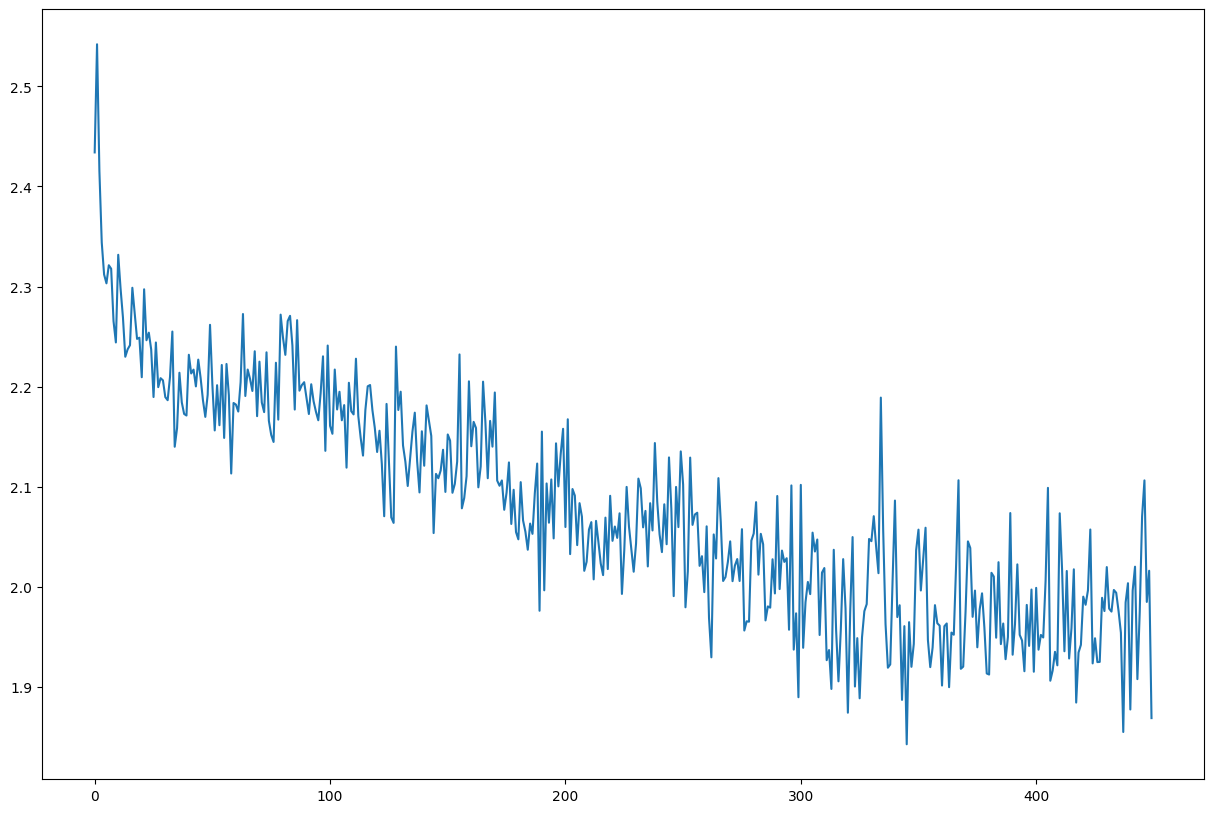

In [49]:
VIT_model = VisionTransformer(img_size=img_size,
                             patch_size=patch_size,
                             in_channel=in_channel,
                             embedding_dim =embedding_dim,
                             num_heads =num_heads,
                             n_attention_layer=n_attention_layer,
                             hidden_dim_scale= hidden_dim_scale,
                             mlp_dropout =mlp_dropout,
                             attn_dropout=attn_dropout ,
                             has_attn_dropout=has_attn_dropout).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    VIT_model = nn.DataParallel(VIT_model,  device_ids=[0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VIT_model.parameters(), lr=lr,weight_decay=weight_decay)
batch_losses,train_accuracy, val_accuracy, test_accuracy = train_model(model=VIT_model,
                                                                       optimizer=optimizer,
                                                                       loss_function=criterion,
                                                                       train_loader=train_loader,
                                                                       val_loader=valid_loader,
                                                                       test_loader=test_loader,
                                                                       num_classes=num_classes)



fig = plt.figure(figsize=(15,10))
plt.plot(batch_losses)
plt.xlabel(f'Iterations with (total # of Epochs ={num_of_epochs})')
plt.ylabel('Loss')
plt.savefig(f"Transformer_Ouputs/Batch_losses_wih_epochs_{num_of_epochs}")

In [55]:
def train_for_different_patches_OR_for_different_Attention_Heads(patch_size_list=None,num_heads_list=None):
    accuracies= [[],[],[]]

    if patch_size_list!=None:
        for p_size in patch_size_list:
            print(f"\n######### Training for Patch_size: {p_size} #########\n")
            VIT_model = VisionTransformer(img_size=img_size,
                                     patch_size=p_size,
                                     in_channel=in_channel,
                                     embedding_dim =embedding_dim,
                                     num_heads =num_heads,
                                     n_attention_layer=n_attention_layer,
                                     hidden_dim_scale= hidden_dim_scale,
                                     mlp_dropout =mlp_dropout,
                                     attn_dropout=attn_dropout ,
                                     has_attn_dropout=has_attn_dropout).to(device)

            if (device.type == 'cuda') and (ngpu > 1):
                VIT_model = nn.DataParallel(VIT_model, device_ids=[0])
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(VIT_model.parameters(),lr=lr,weight_decay=weight_decay)
            batch_size = 100
            batch_losses_model ,train_accuracy, val_accuracy, test_accuracy= train_model(model=VIT_model,
                                                                                         optimizer=optimizer,
                                                                                         loss_function=criterion,
                                                                                         train_loader=train_loader,
                                                                                         val_loader =valid_loader,
                                                                                         test_loader = test_loader,
                                                                                         num_classes=num_classes,
                                                                                         num_of_epochs=num_of_epochs)

            accuracies[0].append(train_accuracy)
            accuracies[1].append(val_accuracy)
            accuracies[2].append(test_accuracy)

        fig = plt.figure(figsize=(15,10))
        plt.xlabel(f'Patch Size (# of Epochs ={num_of_epochs})')
        plt.ylabel('Accuracy')
        plt.plot(patch_size_list,accuracies[0],label="Training")

        plt.plot(patch_size_list,accuracies[1],label="Validation")
        plt.plot(patch_size_list,accuracies[2],label="Test")
        plt.legend()

        plt.savefig(f"Transformer_Ouputs/Accuracies with different_patch_size_wih_epochs_{num_of_epochs}")
        plt.show()

    elif num_heads_list!=None:
        for num_head in num_heads_list:
            print(f"\n######## Training for Num_of_Attention_Heads: {num_head} ########\n")
            VIT_model = VisionTransformer(img_size=img_size,
                                     patch_size=patch_size,
                                     in_channel=in_channel,
                                     embedding_dim =embedding_dim,
                                     num_heads =num_head,
                                     n_attention_layer=n_attention_layer,
                                     hidden_dim_scale= hidden_dim_scale,
                                     mlp_dropout =mlp_dropout,
                                     attn_dropout=attn_dropout ,
                                     has_attn_dropout=has_attn_dropout).to(device)

            if (device.type == 'cuda') and (ngpu > 1):
                VIT_model = nn.DataParallel(VIT_model, device_ids=[0])
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(VIT_model.parameters(), lr=lr,weight_decay=weight_decay)
            batch_size = 100
            batch_losses_model ,train_accuracy, val_accuracy, test_accuracy= train_model(model=VIT_model,
                                                                                         optimizer=optimizer,
                                                                                         loss_function=criterion,
                                                                                         train_loader=train_loader,
                                                                                         val_loader =valid_loader,
                                                                                         test_loader = test_loader,
                                                                                         num_classes=num_classes,
                                                                                         num_of_epochs=num_of_epochs)

            accuracies[0].append(train_accuracy)
            accuracies[1].append(val_accuracy)
            accuracies[2].append(test_accuracy)


        fig = plt.figure(figsize=(15,10))
        plt.xlabel(f'# of Attention Heads (# of Epochs ={num_of_epochs})')
        plt.ylabel('Accuracy')
        plt.plot(num_heads_list,accuracies[0],label="Training")

        plt.plot(num_heads_list,accuracies[1],label="Validation")
        plt.plot(num_heads_list,accuracies[2],label="Test")
        plt.legend()

        plt.savefig(f"Transformer_Ouputs/Accuracies with different_Attention_Heads_wih_epochs_{num_of_epochs}")
        plt.show()

    return accuracies


######### Training for Patch_size: 4 #########

Training Started


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [1/2] 	 batch: [50/225]   Training loss: 2.30121177  Validation_loss: 2.26415506
Epoch: [1/2] 	 batch: [100/225]   Training loss: 2.21815889  Validation_loss: 2.22130561
Epoch: [1/2] 	 batch: [150/225]   Training loss: 2.19748558  Validation_loss: 2.17791851
Epoch: [1/2] 	 batch: [200/225]   Training loss: 2.19388906  Validation_loss: 2.15820868
Epoch: [2/2] 	 batch: [50/225]   Training loss: 2.10146795  Validation_loss: 2.09348224
Epoch: [2/2] 	 batch: [100/225]   Training loss: 2.06449602  Validation_loss: 2.10488571
Epoch: [2/2] 	 batch: [150/225]   Training loss: 2.04565781  Validation_loss: 2.06027388
Epoch: [2/2] 	 batch: [200/225]   Training loss: 2.04907593  Validation_loss: 2.04539102

 #######Calculating Train Accuracy########


225it [00:57,  3.94it/s]


 #######Calculating Valid Accuracy########



13it [00:06,  1.97it/s]


 ##### Calculating Test Accuracy



25it [00:12,  1.93it/s]


 Total_Number_of_Epochs: 2, Train_Accuracy: 25.82%    Valid_Accuracy: 25.40%    Test_Accuracy: 25.68%

######### Training for Patch_size: 8 #########

Training Started
Epoch: [1/2] 	 batch: [50/225]   Training loss: 2.31350836  Validation_loss: 2.20829003
Epoch: [1/2] 	 batch: [100/225]   Training loss: 2.16252852  Validation_loss: 2.15359347
Epoch: [1/2] 	 batch: [150/225]   Training loss: 2.10358214  Validation_loss: 2.12178360
Epoch: [1/2] 	 batch: [200/225]   Training loss: 2.08010021  Validation_loss: 2.07639636
Epoch: [2/2] 	 batch: [50/225]   Training loss: 2.05191946  Validation_loss: 2.02500600
Epoch: [2/2] 	 batch: [100/225]   Training loss: 2.02339193  Validation_loss: 2.05643705
Epoch: [2/2] 	 batch: [150/225]   Training loss: 1.98946871  Validation_loss: 1.98076371
Epoch: [2/2] 	 batch: [200/225]   Training loss: 1.98250367  Validation_loss: 1.96502962

 #######Calculating Train Accuracy########


225it [00:15, 14.66it/s]


 #######Calculating Valid Accuracy########



13it [00:01,  6.74it/s]


 ##### Calculating Test Accuracy



25it [00:03,  7.17it/s]


 Total_Number_of_Epochs: 2, Train_Accuracy: 24.45%    Valid_Accuracy: 23.44%    Test_Accuracy: 24.30%

######### Training for Patch_size: 16 #########

Training Started
Epoch: [1/2] 	 batch: [50/225]   Training loss: 2.32603012  Validation_loss: 2.14299116
Epoch: [1/2] 	 batch: [100/225]   Training loss: 2.11300626  Validation_loss: 2.07444233
Epoch: [1/2] 	 batch: [150/225]   Training loss: 2.03913144  Validation_loss: 2.07509890
Epoch: [1/2] 	 batch: [200/225]   Training loss: 2.03108231  Validation_loss: 2.01267466
Epoch: [2/2] 	 batch: [50/225]   Training loss: 1.96389125  Validation_loss: 1.98638458
Epoch: [2/2] 	 batch: [100/225]   Training loss: 1.93801333  Validation_loss: 1.95162186
Epoch: [2/2] 	 batch: [150/225]   Training loss: 1.94574803  Validation_loss: 1.97058719
Epoch: [2/2] 	 batch: [200/225]   Training loss: 1.98538412  Validation_loss: 1.97995338

 #######Calculating Train Accuracy########


225it [00:08, 25.09it/s]


 #######Calculating Valid Accuracy########



13it [00:00, 13.03it/s]


 ##### Calculating Test Accuracy



25it [00:01, 14.35it/s]


 Total_Number_of_Epochs: 2, Train_Accuracy: 30.61%    Valid_Accuracy: 30.34%    Test_Accuracy: 30.58%


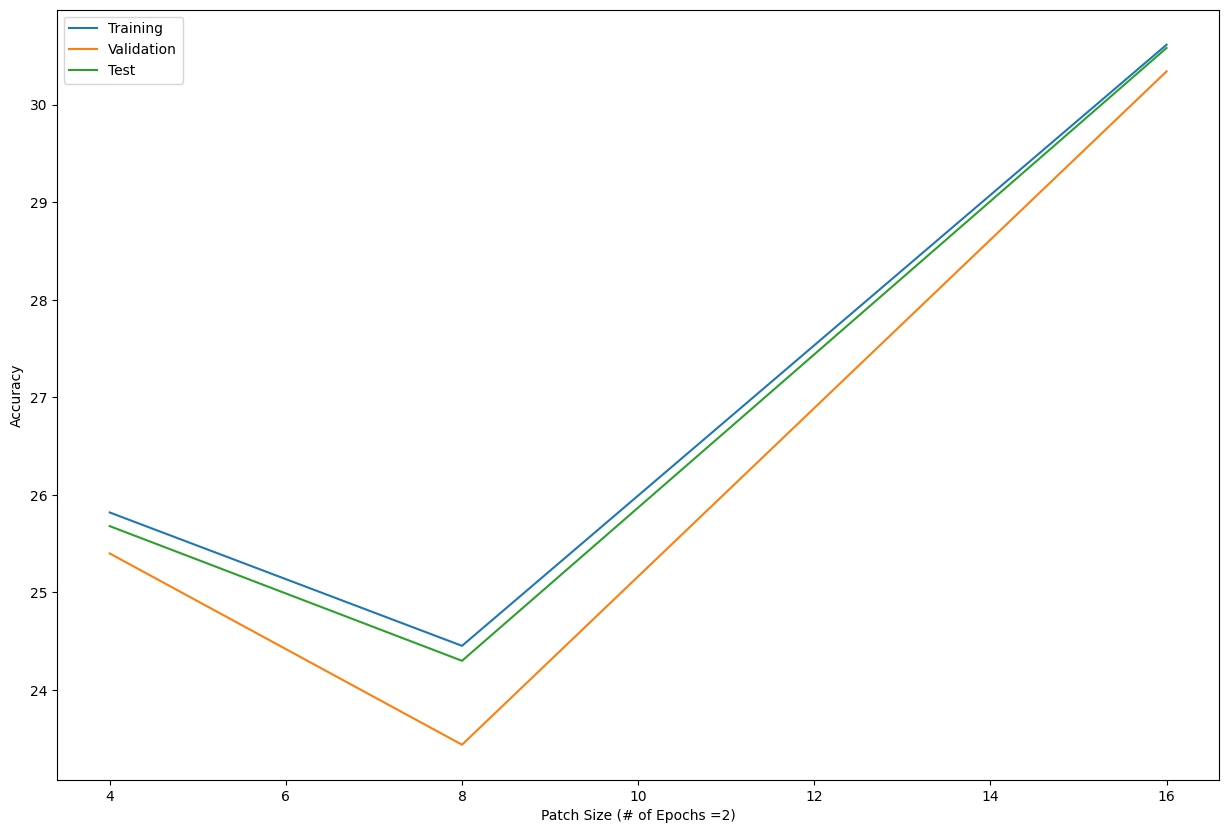

In [56]:
num_of_epochs = 2
patch_based_accuracies = train_for_different_patches_OR_for_different_Attention_Heads(patch_size_list=[4,8,16])